# CIFAR-10 Double Descent Experiments

This notebook demonstrates the double descent phenomenon in deep learning using CIFAR-10 dataset.

## What is Double Descent?

Double descent refers to a phenomenon where the test error:
1. First decreases (normal learning)
2. Then increases near the interpolation threshold (where training error ≈ 0)
3. Finally decreases again as model capacity or training time increases

We'll explore two types of double descent:
- Model-wise: varying model width/parameter count
- Epoch-wise: fixing a large model and training for many epochs




In [1]:
# Import required libraries
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dataclasses import dataclass
from typing import List
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [2]:
# Data loading and preprocessing
def load_cifar10(data_dir, train_fraction=1.0, label_noise=0.0, seed=42):
    """
    Load and preprocess CIFAR-10 dataset with optional label noise and subset selection.
    
    Args:
        data_dir (str): Directory to store/load the dataset
        train_fraction (float): Fraction of training data to use (default: 1.0)
        label_noise (float): Fraction of training labels to corrupt (default: 0.0)
        seed (int): Random seed for reproducibility
        
    Returns:
        tuple: (train_dataset, test_dataset)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_ds = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform)
    test_ds = datasets.CIFAR10(data_dir, train=False, transform=transform)
    
    if train_fraction < 1.0:
        num_train = len(train_ds)
        indices = list(range(num_train))
        random.seed(seed)
        random.shuffle(indices)
        split = int(np.floor(train_fraction * num_train))
        train_ds = torch.utils.data.Subset(train_ds, indices[:split])
    
    if label_noise > 0:
        random.seed(seed)
        num_classes = 10
        num_train = len(train_ds)
        num_noise = int(label_noise * num_train)
        noise_indices = random.sample(range(num_train), num_noise)
        
        if hasattr(train_ds, 'targets'):
            for idx in noise_indices:
                train_ds.targets[idx] = random.randint(0, num_classes-1)
        else:  # For Subset dataset
            dataset = train_ds.dataset
            indices = train_ds.indices
            for idx in noise_indices:
                dataset.targets[indices[idx]] = random.randint(0, num_classes-1)
    
    return train_ds, test_ds


In [3]:
# Model definition
class SimpleCNN(torch.nn.Module):
    """
    A simple CNN with adjustable width for CIFAR-10 classification.
    The width parameter controls the number of channels in each layer.
    """
    def __init__(self, width=64):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, width, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(width, width*2, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(width*2, width*4, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(4*4*width*4, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [4]:
# Training and evaluation functions
def train_one_epoch(model, loader, optimizer, device, scaler=None):
    """
    Train the model for one epoch.
    
    Args:
        model: The neural network model
        loader: DataLoader for training data
        optimizer: The optimizer
        device: Device to train on (cuda/cpu)
        scaler: GradScaler for mixed precision training (optional)
    
    Returns:
        tuple: (average loss, accuracy)
    """
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        if scaler is None:
            outputs = model(images)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
        else:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(images)
                loss = F.cross_entropy(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        running_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)
        
    return running_loss / total, correct / total

def evaluate(model, loader, device):
    """
    Evaluate the model on the given data loader.
    
    Args:
        model: The neural network model
        loader: DataLoader for evaluation
        device: Device to evaluate on (cuda/cpu)
    
    Returns:
        tuple: (average loss, accuracy)
    """
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, targets)
            running_loss += loss.item() * images.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
            
    return running_loss / total, correct / total


In [5]:
# Configuration class
@dataclass
class Config:
    """Configuration for double descent experiments"""
    experiment: str  # 'modelwise' or 'epochwise'
    widths: List[int]  # List of model widths to test (for modelwise)
    width: int  # Single model width (for epochwise)
    epochs: int  # Number of training epochs
    batch_size: int  # Batch size for training
    lr: float  # Learning rate
    weight_decay: float  # Weight decay for regularization
    label_noise: float  # Fraction of training labels to corrupt
    train_fraction: float  # Fraction of training data to use
    data_dir: str  # Directory for dataset
    results_dir: str  # Directory for saving results
    repeats: int  # Number of repetitions per configuration
    seed: int  # Random seed
    use_amp: bool  # Whether to use automatic mixed precision


In [6]:
# Experiment running function
def run_modelwise(cfg: Config):
    """
    Run model-wise double descent experiment.
    Varies model width while keeping other parameters fixed.
    """
    os.makedirs(cfg.results_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data loading
    train_ds, test_ds = load_cifar10(cfg.data_dir, cfg.train_fraction, cfg.label_noise, seed=cfg.seed)
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
    
    # Results tracking
    lines = ["width,params,repeat,epoch,train_loss,train_acc,test_loss,test_acc"]
    
    # Experiment loop
    for w in cfg.widths:
        for r in range(cfg.repeats):
            set_seed(cfg.seed + 1000 * r + w)
            model = SimpleCNN(width=w).to(device)
            params = count_parameters(model)
            
            optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9, weight_decay=cfg.weight_decay)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
            scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp and device.type == 'cuda')
            
            pbar = tqdm(range(1, cfg.epochs + 1), desc=f"width={w} rep={r}")
            for epoch in pbar:
                train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, scaler)
                test_loss, test_acc = evaluate(model, test_loader, device)
                scheduler.step()
                
                pbar.set_postfix({
                    "train_acc": f"{train_acc*100:.1f}",
                    "test_acc": f"{test_acc*100:.1f}"
                })
                
                lines.append(f"{w},{params},{r},{epoch},{train_loss:.6f},"
                           f"{train_acc:.6f},{test_loss:.6f},{test_acc:.6f}")
                
            # Save results after each model
            with open(os.path.join(cfg.results_dir, "modelwise_log.csv"), "w") as f:
                f.write("\n".join(lines))
                
    return pd.read_csv(os.path.join(cfg.results_dir, "modelwise_log.csv"))


## Running the Experiments

Now let's set up and run our experiments. We'll demonstrate both model-wise and epoch-wise double descent.

### Model-wise Double Descent
We'll run experiments with:
- Multiple model widths (1, 2, 4, 8, 16)
- Reduced training set (20%)
- Added label noise (20%)
- Multiple repeats for stability




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:04<00:00, 39.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/tmp/ipykernel_37978/1442528775.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp and device.type == 'cuda')
width=16 rep=2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [10:49<00:00,  3.25s/it, train_acc=99.9, test_acc=37.2]


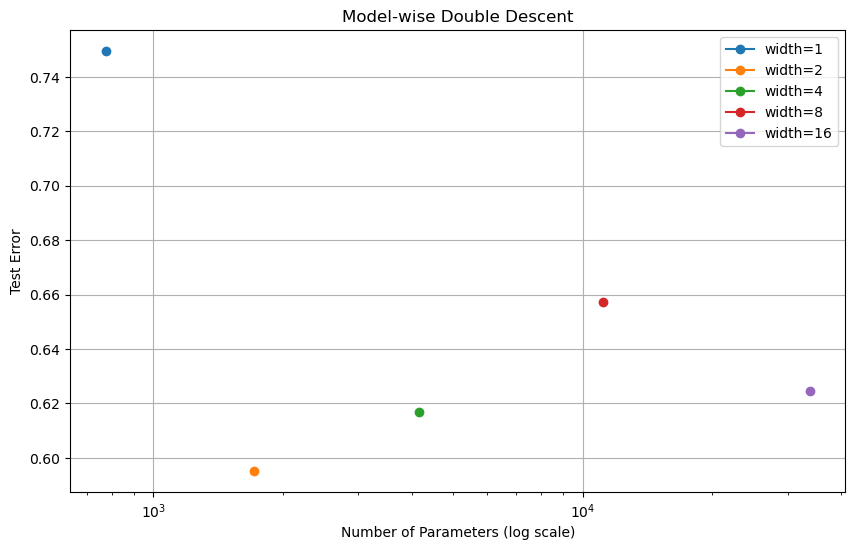

In [7]:
# Run model-wise experiment
modelwise_config = Config(
    experiment="modelwise",
    widths=[1, 2, 4, 8, 16],
    width=0,  # not used for modelwise
    epochs=200,
    batch_size=128,
    lr=0.1,
    weight_decay=0.0,  # minimal regularization
    label_noise=0.2,
    train_fraction=0.2,
    data_dir="./data",
    results_dir="./results_modelwise",
    repeats=3,
    seed=42,
    use_amp=True
)

# Run the experiment
results_df = run_modelwise(modelwise_config)

# Plot results
plt.figure(figsize=(10, 6))
for w in modelwise_config.widths:
    df_w = results_df[results_df['width'] == w]
    params = df_w['params'].iloc[0]
    test_error = 1 - df_w.groupby('epoch')['test_acc'].mean()
    plt.semilogx(params, test_error.iloc[-1], 'o-', label=f'width={w}')

plt.xlabel('Number of Parameters (log scale)')
plt.ylabel('Test Error')
plt.title('Model-wise Double Descent')
plt.grid(True)
plt.legend()
plt.show()
